# Machine Learning (second part): Intermediate report

*Write your name and your student ID below.*

In [1]:
# Modify these lines./
student_name = 'Fueki Masao'
student_id = '20M14894'

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following four problems, and submit the notebook file (`.ipynb`) on OCW. **We do not accept a report in other formats (e.g., Word, PDF, HTML)**. You can use any deep learning library for completing this report. Write a code at the specified cell in the notebook. You can add more cells if necessary. Submit this report even if you cannot solve all problems.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearning/blob/master/notebook/binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearning/blob/master/notebook/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

In [68]:
# include
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cv2

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in accuracy.

One can use the same code shown in the lecture. Write a code here and show the output.

shapetorch.Size([128, 1, 28, 28])


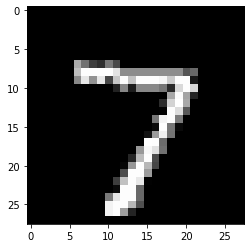

In [5]:
# MNISTのダウンロード
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))]
     )

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 正常に動作しているのか確認用のデータローダー
conf_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
conf_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# ダウンロードされているのか確認してみる
for data, label in conf_dataloader:
    break

print(f'shape{data.shape}')
plt.imshow(np.asarray(to_pil(data[0])), cmap='gray')
plt.show()

In [6]:
# 受け取ったdataの変換を見ていく

conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5))
x = conv1(data)
print(f'conv1:{x.shape}')  # [batch_size, channel, w, h]

pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
x = pool(x)
print(f'pool:{x.shape}')  # [batch_size, channel, w, h]

conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))
x = conv2(x)
print(f'conv2:{x.shape}')  # [batch_size, channel, w, h]

x = pool(x)
print(f'pool:{x.shape}')  # [batch_size, channel, w, h]

# 平坦化
x = x.view(-1, 16 * 4 * 4)

fc1 = nn.Linear(in_features=16*4*4, out_features=120)
x = fc1(x)
print(f'fc1:{x.shape}')  # [batch_size, neuron_size]

fc2 = nn.Linear(in_features=120, out_features=84)
x = fc2(x)
print(f'fc2:{x.shape}')  # [batch_size, neuron_size]

fc3 = nn.Linear(in_features=84, out_features=10)
x = fc3(x)
print(f'fc3:{x.shape}')  # [batch_size, neuron_size]

conv1:torch.Size([128, 6, 24, 24])
pool:torch.Size([128, 6, 12, 12])
conv2:torch.Size([128, 16, 8, 8])
pool:torch.Size([128, 16, 4, 4])
fc1:torch.Size([128, 120])
fc2:torch.Size([128, 84])
fc3:torch.Size([128, 10])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def test_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する

# モデルの定義
model = CNN().to(device)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

In [10]:
# 学習
## 設定
epochs = 10  # エポック数を設定する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
hist = {'loss': [], 'accuracy': []}

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)

    print(f'epoch: {epoch+1}, loss: {train_loss:.3}')

epoch: 1, loss: 0.394
epoch: 2, loss: 0.0872
epoch: 3, loss: 0.0592
epoch: 4, loss: 0.0473
epoch: 5, loss: 0.0394
epoch: 6, loss: 0.0324
epoch: 7, loss: 0.0276
epoch: 8, loss: 0.0239
epoch: 9, loss: 0.0209
epoch: 10, loss: 0.0193


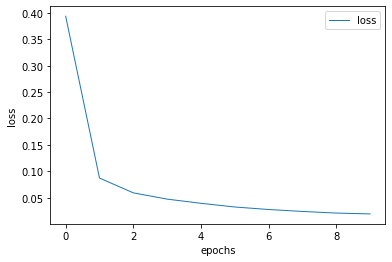

In [11]:
# 学習結果
loss = hist['loss']

fig = plt.figure()
plt.plot(range(len(loss)), loss, linewidth=1, label='loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
test_loss = 0.
test_acc = 0.

label_list = []
pred_list = []
pred_prob_list = []

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    # confusion matrixのため
    label_list += t.tolist()
    pred_list += preds.argmax(dim=-1).tolist()

    # Top-3 easyのため
    pred_prob_list += F.softmax(preds, dim=1).tolist()

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

test_loss: 0.031, test_acc: 0.990


テストデータの精度は99%となった。

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [13]:
confusion_matrix(label_list, pred_list)

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   2, 1122,    1,    5,    0,    0,    1,    2,    2,    0],
       [   0,    0, 1029,    0,    0,    0,    0,    3,    0,    0],
       [   0,    0,    2, 1001,    0,    3,    0,    1,    3,    0],
       [   0,    0,    2,    0,  973,    0,    1,    2,    1,    3],
       [   2,    0,    0,    8,    0,  875,    3,    1,    0,    3],
       [   5,    2,    1,    0,    2,    1,  947,    0,    0,    0],
       [   0,    2,    4,    0,    1,    0,    0, 1019,    1,    1],
       [   2,    0,    4,    2,    0,    3,    1,    1,  960,    1],
       [   0,    1,    0,    1,    8,    2,    0,    6,    0,  991]])

## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (for easy three examples) and $y_n \neq \hat{y}_n$ (for confusing three examples).

For each example, please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$ together with the image $x_n$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images, in other words, for six images in total).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [43]:
df = pd.DataFrame(pred_prob_list)
df['pred_num'] = pred_list
df['label'] = label_list
df['pred_prob'] = df.iloc[:, 0:10].apply(lambda x: max(x), axis=1)
df['TF'] = np.array(label_list) == np.array(pred_list)
df

,0,1,2,3,4,5,6,7,8,9,pred_num,label,pred_prob,TF
0,1.086234e-09,1.508167e-07,2.491621e-06,6.087724e-07,5.753747e-10,2.048942e-10,1.489976e-14,9.999938e-01,5.109993e-08,2.962056e-06,7,7,0.999994,True
1,3.415229e-08,5.721128e-10,1.000000e+00,1.163085e-10,1.941950e-15,7.914062e-16,2.834324e-11,6.628003e-12,1.878454e-08,6.181945e-14,2,2,1.000000,True
2,3.538245e-08,9.998523e-01,6.674794e-06,1.684726e-09,7.140390e-05,1.270902e-09,1.259878e-08,6.751590e-05,1.722467e-06,3.419801e-07,1,1,0.999852,True
3,9.999989e-01,9.615393e-12,3.536744e-07,1.095814e-09,1.756102e-10,1.960864e-10,7.763319e-07,2.304160e-10,9.352819e-09,6.432483e-09,0,0,0.999999,True
4,2.025701e-11,5.088566e-10,3.265272e-10,2.830516e-11,9.999450e-01,7.840471e-13,1.684061e-11,1.184509e-09,1.554041e-09,5.493100e-05,4,4,0.999945,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5.588339e-10,3.103755e-07,9.999974e-01,4.904550e-08,2.809789e-14,3.446840e-16,5.785585e-13,2.295299e-06,1.280082e-08,1.116618e-13,2,2,0.999997,True
9996,5.793177e-11,1.148728e-08,1.433134e-09,9.999994e-01,3.179668e-13,3.337728e-07,3.327487e-13,3.429357e-09,7.491733e-09,2.435899e-07,3,3,0.999999,True
9997,1.980748e-13,6.864778e-10,2.093362e-12,4.140140e-13,1.000000e+00,2.448541e-12,6.941753e-13,2.273696e-09,3.974683e-09,2.057646e-09,4,4,1.000000,True
9998,5.705791e-06,8.252726e-11,6.025616e-11,8.172752e-07,4.228275e-12,9.999439e-01,1.729194e-05,1.132212e-11,3.228962e-05,3.556126e-08,5,5,0.999944,True


In [44]:
true_index = df.sort_values('pred_prob', ascending=False).query('TF == True').reset_index().iloc[0:3]
true_index

,index,0,1,2,3,4,5,6,7,8,9,pred_num,label,pred_prob,TF
0,5000,2.009825e-15,1.549999e-10,6.790099e-09,1.000000e+00,4.743993e-11,5.899588e-09,3.360155e-14,4.158952e-10,1.880393e-08,1.249139e-10,3,3,1.0,True
1,6711,1.000000e+00,5.699076e-13,5.182748e-09,2.207950e-12,1.210831e-11,3.839387e-10,4.256030e-09,4.844152e-11,4.925381e-09,2.142150e-08,0,0,1.0,True
2,6875,4.193871e-15,1.773950e-10,6.307180e-10,1.000000e+00,8.577298e-14,1.010675e-10,1.407875e-17,4.831110e-09,3.787207e-11,1.591618e-09,3,3,1.0,True


In [45]:
false_index = df.sort_values('pred_prob', ascending=False).query('TF == False').reset_index().iloc[0:3]
false_index

,index,0,1,2,3,4,5,6,7,8,9,pred_num,label,pred_prob,TF
0,3520,9.525816e-07,2.322262e-09,2.151725e-07,1.930466e-09,9.998950e-01,1.308101e-06,8.698719e-05,2.252487e-07,0.000015,4.126632e-07,4,6,0.999895,False
1,2597,1.874009e-11,8.465464e-08,5.869381e-09,9.996847e-01,1.338939e-10,3.045952e-04,3.731104e-09,9.018275e-10,0.000008,2.671824e-06,3,5,0.999685,False
2,2654,6.251208e-07,9.992616e-01,6.611407e-05,1.522519e-06,2.797026e-05,2.695363e-07,6.399858e-04,3.930310e-08,0.000002,2.287943e-08,1,6,0.999262,False


誤識別しているが、予測確率が高いtop3

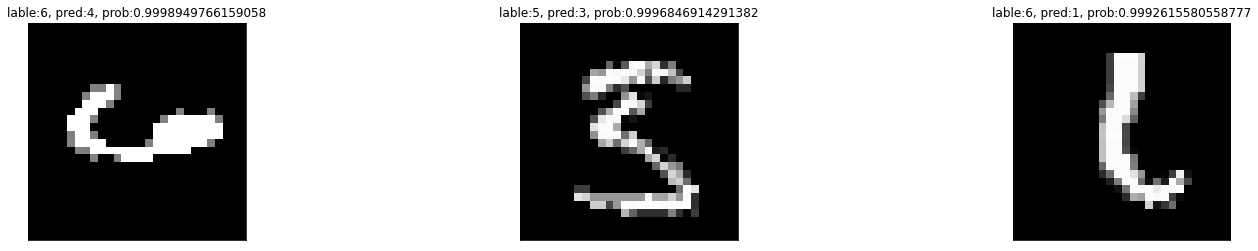

In [58]:
fig = plt.figure(figsize=(25, 4))
for i in range(len(false_index)):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    plt.imshow(np.asarray(to_pil(test_dataset[false_index['index'].iloc[i]][0])), cmap='gray')
    ax.set_title(f"lable:{false_index['label'].iloc[i]}, prexd:{false_index['pred_num'].iloc[i]}, prob:{false_index['pred_prob'].iloc[i]}")

正常に識別していて、予測確率が高いtop3

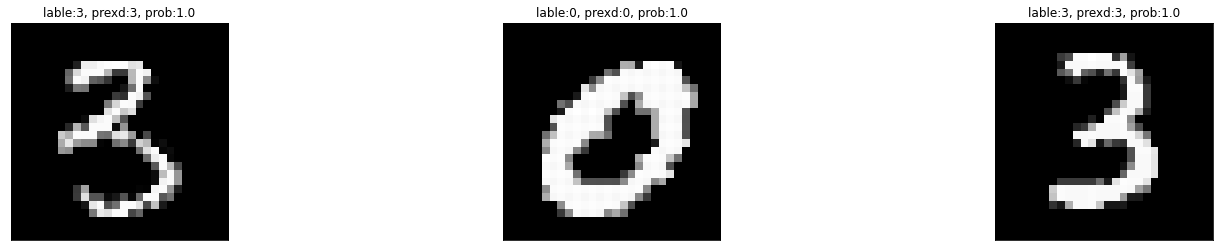

In [59]:
fig = plt.figure(figsize=(25, 4))
for i in range(len(true_index)):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    plt.imshow(np.asarray(to_pil(test_dataset[true_index['index'].iloc[i]][0])), cmap='gray')
    ax.set_title(f"lable:{true_index['label'].iloc[i]}, prexd:{true_index['pred_num'].iloc[i]}, prob:{true_index['pred_prob'].iloc[i]}")

## 4. Recognize your handwritten digits

Prepare three image files each of which presents a digit written by you. For each image, apply the MNIST model you trained, and show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ (10-dimensional vector) for all possible digits as well as the image itself.

Please refer to [this notebook](https://colab.research.google.com/notebooks/io.ipynb) about how to upload a file to Google Colaboratory.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Image #1

Write the code to show the image #1 here.

(284, 284)


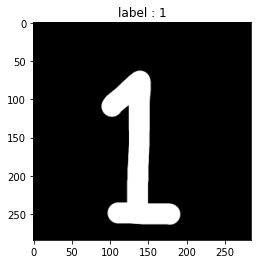

In [113]:
img = cv2.cvtColor(cv2.imread('/content/drive/My Drive/先端機械学習/sample_img/sample_1.png'), cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title('label : 1')
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

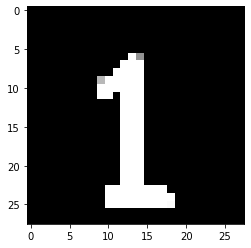

In [114]:
img = cv2.resize(img, (28, 28))
plt.imshow(img, cmap='gray')

In [116]:
img_tensor = transform(img)
model(img_tensor.unsqueeze(0).to(device)).argmax(-1).item()

1

In [134]:
print(F.softmax(model(img_tensor.unsqueeze(0).to(device)), -1).squeeze(0).data.cpu())

tensor([9.7660e-06, 9.9092e-01, 7.0471e-03, 7.6758e-07, 5.5566e-06, 1.2551e-06,
        2.9570e-06, 1.1209e-03, 8.6502e-04, 2.2589e-05])


### Image #2

Write the code to show the image #2 here.

(284, 284)


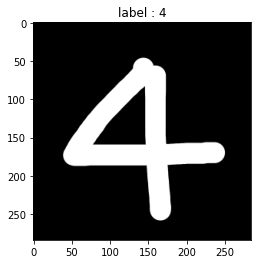

In [135]:
img = cv2.cvtColor(cv2.imread('/content/drive/My Drive/先端機械学習/sample_img/sample_4.png'), cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title('label : 4')
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.


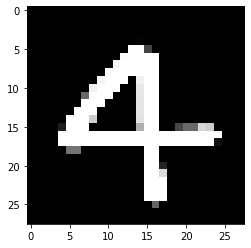

In [137]:
img = cv2.resize(img, (28, 28))
plt.imshow(img, cmap='gray')

In [138]:
img_tensor = transform(img)
model(img_tensor.unsqueeze(0).to(device)).argmax(-1).item()

4

In [139]:
print(F.softmax(model(img_tensor.unsqueeze(0).to(device)), -1).squeeze(0).data.cpu())

tensor([1.2456e-11, 3.3814e-08, 1.3652e-04, 4.1911e-10, 9.9985e-01, 9.3034e-13,
        8.6064e-12, 1.2857e-06, 4.0360e-08, 1.5892e-05])


### Image #3

Write the code to show the image #3 here.

(284, 284)


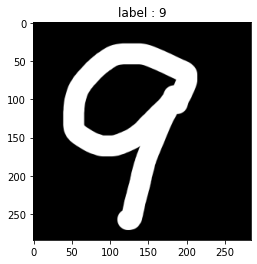

In [140]:
img = cv2.cvtColor(cv2.imread('/content/drive/My Drive/先端機械学習/sample_img/sample_9.png'), cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title('label : 9')
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

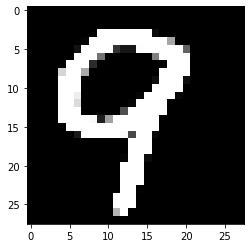

In [141]:
img = cv2.resize(img, (28, 28))
plt.imshow(img, cmap='gray')

In [142]:
img_tensor = transform(img)
model(img_tensor.unsqueeze(0).to(device)).argmax(-1).item()

9

In [143]:
print(F.softmax(model(img_tensor.unsqueeze(0).to(device)), -1).squeeze(0).data.cpu())

tensor([1.5265e-09, 1.6474e-06, 3.4362e-07, 3.0347e-05, 1.8342e-04, 3.6012e-09,
        2.1635e-12, 1.0522e-03, 2.1226e-02, 9.7751e-01])
